## 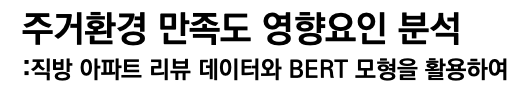




**202249754 도시공학과 권준현**

**텍스트기반경제사회 분석**

요약: 본 연구는 직방의 아파트 리뷰 데이터를 수집하고 딥러닝 기반의 자연어 처리 모형인 BERT와 기계학습 방법론인 SHAPley Value 등을 활용하여 주거환경 만족도의 영향요인을 분석하였다. 구체적으로는 아파트 리뷰의 내용을 바탕으로 주거환경 만족도의 긍정적, 부정적 영향 요인을 도출하고 서울 시 내 권역별로 나타나는 차이를 비교하였으며, 이들의 연관어를 도출해 주거환경 만족도 개선을 위한 주요 사항을 제시하였다.


*본 노트북 파일은 전체 과정에서 활용한 코드를 간략한 주석과 함께 서술하고 있으며 상세한 내용 및 분석 결과는 별도로 보고서에 작성함*

## 1. 직방 리뷰 수집

In [7]:
# 크롤링 프레임워크 참고 코드: https://itlamp.tistory.com/16 
# 위의 방법을 참고하였으나, 주요 작동 방식은 연구의 목적에 맞게 변경하여 사용함
# 참고 코드의 경우 geohash(공간단위) 별로 리뷰를 수집하나, 본 연구에서는 아파트 단지 별로 모든 리뷰를 수집하여 취합함

In [1]:
import requests
import json
import csv
from tqdm import tqdm
import pandas as pd

In [2]:
#GeoHash는 공간단위로 직방에서 지역 검색을 위해 설정된 단위임
#서울지역은 총 4개의 큰 Geohash 영역에 걸쳐져 있음(각 hash는 32개의 하위 영역을 포함)

seoul =  ['wydq','wydm','wydj','wydn'] 

#상위 geohash를 입력하면 이를 구성하는 하위 hash 반환
def geo(code):     
    geos = []
    for i in range(10):
        geos.append(code+str(i))
    startIdx = ord('b')
    endIdx = ord('z')
    for i in range(startIdx, endIdx + 1):
        if (chr(i) != 'i' and chr(i) != 'l' and chr(i) != 'o'):
            geos.append(code + chr(i))
 
    return geos

#서울 지역의 하위 hash들을 모두 저장
totalGeohash = []
for i in seoul:
    tmp = geo(i)
    for j in tmp:
        totalGeohash.append(j)

len(totalGeohash)

128

In [3]:
#GeoHash 내의 아파트 정보를 모두 수집하는 함수

def getDanji(geo):
  url = 'https://apis.zigbang.com/property/apartments/location/v3?e=&geohash={}&markerType=large&n=&q=type%3Dsales%2Cprice%3D0~-1%2CfloorArea%3D0~-1&s=&serviceType%5B0%5D=apt&serviceType%5B1%5D=offer&serviceType%5B2%5D=preOffer&w='.format(geo)
  req = requests.get(url)
  item = req.json()
  raw = item['filtered']

  apart = []
  for i in raw:
    if i['sido']=="서울특별시": #Geohash는 직사각형으로 일부의 경우 서울 외의 영역도 포함하기에 아파트 주소지가 서울일 경우만 수집
      # 순서대로 id, 이름, 구, 법정동, 좌표, 세대수, 건축년도, 점수, 브랜드, 가격, 면적을 수집함 
      info = [i['id'], i['name'], i['gugun'], i['dong'], i['lat'], i['lng'], i['households'], i['buildDate'], 
              i['score'], i['brand'], i['price'], i['floorArea']]
      apart.append(info)

  return apart

In [4]:
#서울 내 모든 아파트 ID 수집
allApart = []

for i in tqdm(totalGeohash):
  tmp = getDanji(i)
  allApart += tmp

print("\n")
print(len(allApart))
print(allApart[:4]) #샘플출력

ids = [] #아파트의 id 저장
for i in allApart:
  ids.append(i[0])
len(ids)

100%|██████████| 128/128 [01:30<00:00,  1.41it/s]



4724
[[20140, '은평뉴타운제각말5단지(522~528동)', '은평구', '진관동', 37.6388061, 126.934603, 189, 201009, 4.4, '푸르지오', {'rent': {'min': 59000, 'max': 90000, 'avg': 75500, 'perArea': 2021}, 'sales': {'min': 126000, 'max': 156000, 'avg': 134000, 'perArea': 3592}, 'offer': {'min': None, 'max': None, 'avg': None, 'perArea': None}}, {'m2': 107, 'p': 32}], [20141, '은평뉴타운제각말5단지(514~521동)', '은평구', '진관동', 37.63789340258051, 126.93644762307088, 175, 201009, 4, '푸르지오', {'rent': {'min': 63000, 'max': 103000, 'avg': 77000, 'perArea': 1922}, 'sales': {'min': 104000, 'max': 150000, 'avg': 121000, 'perArea': 3035}, 'offer': {'min': None, 'max': None, 'avg': None, 'perArea': None}}, {'m2': 107, 'p': 32}], [20142, '은평뉴타운제각말5단지(501~513동)', '은평구', '진관동', 37.6366669, 126.935817, 330, 201009, 4.4, '푸르지오', {'rent': {'min': 60000, 'max': 88000, 'avg': 68500, 'perArea': 1762}, 'sales': {'min': 98000, 'max': 131000, 'avg': 111000, 'perArea': 2866}, 'offer': {'min': None, 'max': None, 'avg': None, 'perArea': None}}, {'m2': 10

4724

In [5]:
#단지 ID로 리뷰 가져오는 함수
def revCrawl(danji):
  revList = []
  u = 'https://apis.zigbang.com/property/apartments/{}/reviews/v1'.format(danji)
  req = requests.get(u)
  info = req.json()
  raw = info['data']

  for i in raw:
    tmp = [danji]
    rev = ['id', 'age', 'sex', 'married', 'residenceTime', 'residenceType', 'score', 'desc', 'trafficScore', 'trafficDesc', 'aroundScore', 'aroundDesc', 'careScore', 'careDesc', 'residentScore', 'residentDesc', 'regDate']
    for j in rev:
      tmp.append(i[j])
    revList.append(tmp)
  
  return revList

In [6]:
#리뷰 크롤링하여 저장
revs = []
for i in tqdm(ids):
  revs += revCrawl(i)

len(revs)

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


218

In [8]:
# 리뷰 예시
print(revs[0])

[19810, 304135, '20대', '남자', '미혼', '2018년에 거주', '전세 또는 월세', 4, '이정도면 정말 괜찮은 환경과 아이들 키우기도 정말 젛은 아파트 단지인거 같다', 4, '좀 내려오면 바로 버스장이 잇구 오분만 걸어가면 지하철역이 있어서 교통적으러는 매우 편안하다', 4, '교통환격도 좋고 역세권이고 집뒤로는 산이있어서 공기가 좋고 롯데몰도 있기 때문에 환경적인면은 만족스럽가', 2, '단지관리는 평범하다 전혀 못미칠것도 없고 그렇다고 엄청 좋은걸도 아닌 딱 적당하다', 4, '여느 아파트처럼 평범하지만 큰문제 없이 살기좋다 만족한다', '2018.02.09']


In [31]:
#데이터프레임으로 저장
apt_cat = ['id', 'name', 'gu','dong','lat','lng','households','build','score','brand','price','Area']
rev_cat = ['id', 'user', 'age', 'sex', 'married', 'residenceTime', 'residenceType', 'score', 'desc', 'trafficScore', 'trafficDesc', 'aroundScore', 'aroundDesc', 'careScore', 'careDesc', 'residentScore', 'residentDesc', 'regDate']

df_apt = pd.DataFrame(allApart, columns = apt_cat)
df_rev = pd.DataFrame(revs, columns = rev_cat)

df_apt.to_csv('all_apart.csv')
df_rev.to_csv('all_reviews.csv')

## 2. 데이터 전처리

In [ ]:
#필요한 라이브러리 설치 및 import

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy

from hanspell import spell_checker as spell
from pykospacing import Spacing
from konlpy.tag import *
import re 
spacing = Spacing()
okt = Okt()

In [11]:
from tqdm import tqdm

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' 
#불용어 정의
stop_w = '을 를 은 는 이 가 에 로 에게 에게도 으로 단지 아파트 호선 단지 미터 번 이고 분이면 까지 시 분 에서 이나 에는 서울 제로 페이 제로페이 아파트 ㅎ ㅋ ㅜ ㅠ 주었다 점'
stop_w = set(stop_w.split(' '))

def tostr(str_list): #리스트 요소를 하나의 문자열로 반환하는 함수
    result = ""
    for s in str_list:
        result += s + " "
    return result.strip()

def pre(i): #단일 문장에 대한 전처리 진행
  spc = spacing(i) #띄어쓰기 해주고
  spc = re.sub(r"[0-9]","",spc) #숫자 지우기
  for p in punct:  #특수문자 지워주고
      spc = spc.replace(p,'') 
  try:
    pre = spell.check(spc).checked #맞춤법 바꾸고
  except:
    pass
  word_tokens = okt.morphs(pre)
  res = [word for word in word_tokens if not word in stop_w if len(word)>1]  
  return tostr(res)    

def pre_process(revs): #문장들이 저장된 리스트를 입력하면 리스트 모든 요소에 대해 전처리 해 반환
  tmp = []
  for i in tqdm(revs):
    spc = spacing(i) #띄어쓰기 해주고
    spc = re.sub(r"[0-9]","",spc) #숫자 지우기
    for p in punct:  #특수문자 지워주고
        spc = spc.replace(p,'') 
    try:
      pre = spell.check(spc).checked #맞춤법 바꾸고
    except:
      pass
    word_tokens = okt.morphs(pre)
    res = [word for word in word_tokens if not word in stop_w if len(word)>1] 
    tmp.append(tostr(res))
  return tmp

In [13]:
rev = pd.read_csv('all_reviews.csv')
all = rev['desc']
len(all) #전체 리뷰 수 확인(본 노트북 파일의 출력 예시는 일부 리뷰만을 활용함)

100

In [ ]:
processed = pre_process(all) #전처리 진행

In [15]:
#샘플
print(" 전처리 전: \n", all[12])
print("\n 전처리 후: \n", processed[12]) 

 전처리 전: 
 상가가 별로 없다는 단점이 있지만 오히려 그로 인해 차가 막히지 않아 좋다.

 전처리 후: 
 상가 별로 없다는 단점 있지만 오히려 그로 인해 차가 막히지 않아 좋다


In [35]:
#권역구분, 순서대로 구별 코드 지정, 아파트 데이터로부터 아파트 코드별 구 가져오기, 리뷰의 아파트코드로 구 코드 지정 
codes = {'마포구':1,'서대문구':1, '은평구':1, '용산구':2, '종로구':2, '중구':2, '강북구':3, '광진구':3, '노원구':3, '도봉구':3, '동대문구':3, '성동구':3, '성북구':3, '중랑구':3, '강남구':4, '강동구':4, '서초구':4, '송파구':4, '강서구':5, '관악구':5, '구로구':5, '금천구':5, '동작구':5, '양천구':5, '영등포구':5}
apt_gu = dict(zip(df_apt['id'], df_apt['gu']))
area_id = [codes[apt_gu[i]] for i in df_rev['id']]

#df_rev에 전처리 결과, 권역과 연도 추가
df_rev['REVIEW'] = processed
df_rev['AREA'] = area_id
df_rev['YEAR'] = [i[:4] for i in df_rev['regDate']]

In [36]:
#분석에 활용할 df 칼럼만 추출
data = df_rev[['id', 'YEAR','AREA', 'score', 'REVIEW']]

In [ ]:
data = data[data['score']!=3] #3점은 분석에 활용안함
scores = [int(i/3) for i in data.score] #1-2점은 부정(0), 4-5점은 긍정(1) 라벨링
data['pn'] = scores #pn 칼럼에 긍정 부정 라벨링 추가

In [38]:
#권역별 데이터 구분을 위함
area1 = data[data['AREA']==1] 
area2 = data[data['AREA']==2] 
area3 = data[data['AREA']==3] 
area4 = data[data['AREA']==4] 
area5 = data[data['AREA']==5] 

In [39]:
#샘플 출력
area1.sample()

id  YEAR  AREA  score  \
84  19889  2018     1      5   

                                               REVIEW  pn  
84  근처 롯데 스타 필드 병원 들어오거나 예정 이라서 가격 많이 오르고 교통 편리해서 ...   1

## 3. BERT 진행

In [40]:
## 공식 도큐먼트 및 수업 때 활용한 코드 참고

In [43]:
## ***** 중요 ******

to_bert = data #전체 데이터에 대해 진행倖
#to_bert = area1 #BERT에 사용할 권역 지정 
to_bert = data.sample(frac=1) #랜덤 셔플

q = int(len(to_bert) * 0.8) #8:2로 train, test 분리
train, test = to_bert[:q], to_bert[q:]

In [45]:
#필요 패키지 설치 및 import, GPU 사용 가능 확인
!pip install transformers
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

import os

n_devices = torch.cuda.device_count()
print(n_devices)

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

1
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [46]:
#사용할 토크나이저 
multi = 'bert-base-multilingual-cased'

In [47]:
#train set 구성
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.REVIEW] 

tokenizer = BertTokenizer.from_pretrained(multi, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]

m_len = 0
for i in tokenized_texts:
  if len(i)>m_len:
    m_len=len(i)

MAX_LEN = m_len
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train['pn'].values, random_state=42, test_size=0.1) #라벨 설정

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

print('Maxlen: ', m_len)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Maxlen:  114


In [48]:
#test셋 구성
sentences = test['REVIEW'] 
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['pn'].values 

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
#학습 정의
model = BertForSequenceClassification.from_pretrained(multi, num_labels=2).cuda() 
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8) 
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [51]:
#학습 진행
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

for epoch_i in range(0, epochs):
   # Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()
        
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels = b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # Validation
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00

Training complete!


In [52]:
#Validation 진행
#평가
t0 = time.time()
model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 1.00
Test took: 0:00:00


## 4. Word2Vec 연관어 분석

In [55]:
from gensim.models import Word2Vec

#사용할 문장들을 단어 단위의 리스트로 쪼개야 함
rev_list = [i.split(' ') for i in data.REVIEW] 

w2v = Word2Vec(rev_list, size = 100, window = 5, min_count = 5, workers = 4, sg = 1) #sg=0 CBOW, 1 skipgram
w2v.wv.vectors.shape
vocab = w2v.wv.vocab
top10 = sorted(vocab, key=vocab.get, reverse=True)[:10]

In [56]:
for i in top10: #상위 요인 출력 예시
  print(i, w2v.wv.most_similar(i))

롯데 [('가까이', 0.32345712184906006), ('정도', 0.30306583642959595), ('병원', 0.29750123620033264), ('대형', 0.2937231659889221), ('쇼핑몰', 0.28092676401138306), ('만족한다', 0.259258508682251), ('출퇴근', 0.2571900486946106), ('거리', 0.25153833627700806), ('아주', 0.24820318818092346), ('있고', 0.2369799017906189)]
아이 [('좋고', 0.348247230052948), ('있다', 0.3089691698551178), ('생각', 0.27206218242645264), ('시설', 0.2665480971336365), ('걸어서', 0.2518910765647888), ('보다', 0.24792246520519257), ('가까이', 0.2380550056695938), ('지역', 0.2350287139415741), ('있고', 0.23060190677642822), ('학교', 0.22396835684776306)]
공기 [('몰이', 0.28907206654548645), ('좋아요', 0.24247309565544128), ('이용', 0.23851214349269867), ('만족한다', 0.23707400262355804), ('필드', 0.23389822244644165), ('가깝고', 0.22221489250659943), ('북한', 0.21020647883415222), ('구파발역', 0.19380834698677063), ('매우', 0.19304713606834412), ('시설', 0.19105775654315948)]
있고 [('버스', 0.3312615752220154), ('보다', 0.28295037150382996), ('근처', 0.2691721022129059), ('걸어서', 0.268379807472229), 

In [57]:
keyword = '아이'
w2v.wv.most_similar(keyword, topn=5) #특정 키워드의 연관어 상위 특정 개수 출력

[('좋고', 0.348247230052948),
 ('있다', 0.3089691698551178),
 ('생각', 0.27206218242645264),
 ('시설', 0.2665480971336365),
 ('걸어서', 0.2518910765647888)]

## 5. SHAP 분석

In [ ]:
#SHAP Document 참고: https://github.com/slundberg/shap

In [59]:
#SHAP 분석을 위한 준비
!pip install shap
!pip install nlp

import shap
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=m_len, truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

labels = ['Positive', 'Negative'] #긍정(1), 부정(0) 라벨 선언

In [65]:
import re
def custom_tokenizer(s, return_offsets_mapping=True):
      pos = 0
      offset_ranges = []
      input_ids = []
      for m in re.finditer(r"\W", s):
          start, end = m.span(0)
          offset_ranges.append((pos, start))
          input_ids.append(s[pos:start])
          pos = end
      if pos != len(s):
          offset_ranges.append((pos, len(s)))
          input_ids.append(s[pos:])
      out = {}
      out["input_ids"] = input_ids
      if return_offsets_mapping:
          out["offset_mapping"] = offset_ranges
      return out

masker = shap.maskers.Text(custom_tokenizer)
explainer = shap.Explainer(f, masker, output_names=labels)

In [67]:
revs_to_shap = [[i] for i in to_bert.REVIEW] #SHAP 진행할 리뷰들

In [69]:
shap_values = [] #SHAP 결과 저장할 리스트

#SHAP 진행
for i in tqdm(revs_to_shap):
  try:
    shap_values.append(explainer(i))
  except:
    pass

len(shap_values)

100%|██████████| 84/84 [03:00<00:00,  2.15s/it]


84

In [82]:
#SHAP 결과 예시
shap.plots.text(shap_values[7])

In [91]:
#위의 결과를 데이터프레임화하는 코드는 스스로 구축함
#SHAP 결과 점수가 존재하는 모든 단어들 가져오고, 영향력 값들을 저장하기
all_words = {}
word_list = []
for i in shap_values:
  for j in i.data[0]:
    all_words[j] = []
    word_list.append(j)

word_list = list(set(word_list))

for i in shap_values:
  for j in range(len(i)):
    word = i.data[0][j]
    try:
      all_words[word].append(i.values[0][j][1])
    except:
      pass

#샘플
print('모든 단어의 수: ', len(word_list))
print('"마트"의 영향력: ', all_words['마트 '])

모든 단어의 수:  783
"마트"의 영향력:  [0.02415645867586136, 0.02415645867586136]


In [95]:
#영향력이 도출된 단어들에 대해 그 값들을 데이터프레임으로 저장
import numpy as np

all_value = [] #각 단어의 등장 횟수, 평균 영향력, 전체 값을 저장
for i in word_list:
  nums = len(all_words[i])
  if nums > 0:
    token = [i]
    token.append(nums)
    token.append(np.mean(all_words[i]))
    token.append(all_words[i])
    all_value.append(token)

shap_result = pd.DataFrame(columns = ['word', 'count', 'mean', 'abs', 'pn', 'min', 'median ','max'])

for i in all_value:
  a = i[0:3]
  m = np.mean(i[3])
  a.append(abs(m)) #영향력의 부호에 따라 +, - 부여
  if m>0:
    a.append('+')
  else:
    a.append('-')
  a.append(min(i[3]))
  a.append(np.percentile(i[3],50))
  a.append(max(i[3]))
  shap_result.loc[len(shap_result)] = a

final_result = shap_result.sort_values(by=['count'],axis=0, ascending=False) #등장 빈도로 정렬
final_result.head()

word count      mean       abs pn       min   median        max
23  가까이     18  0.085317  0.085317  +  0.037954  0.076200  0.137618
49   근처     10  0.051882  0.051882  + -0.002865  0.058010  0.105254
18   공기     10  0.028925  0.028925  +  0.015686  0.019478  0.057087
51   주변      8  0.070953  0.070953  +  0.028887  0.066436  0.122055
50   아이      8  0.057326  0.057326  +  0.031997  0.064885  0.067538

In [96]:
ordered = final_result.sort_values(by=['abs'],axis=0, ascending=False) #상대적 영향력 크기로 정렬
ordered.head()

word count      mean       abs pn       min   median        max
26    맑은      2  0.155119  0.155119  +  0.155119  0.155119  0.155119
25  출퇴근길      2  0.101580  0.101580  +  0.101580  0.101580  0.101580
10    우선      2  0.095202  0.095202  +  0.095202  0.095202  0.095202
23   가까이     18  0.085317  0.085317  +  0.037954  0.076200  0.137618
37   글쎄요      2  0.082971  0.082971  +  0.082971  0.082971  0.082971

In [97]:
ordered.to_excel('shap_final.xlsx') #엑셀로 출력